In [1]:
#Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
import seaborn as sns

# Import API key
from api_keys import api_key

In [2]:
import json

# adding api_key to base url to obtain FDA information 
base_url = "https://api.fda.gov/drug/event.json?api_key=" + api_key

# changing the output to json 
req = requests.get(base_url)
data = req.json()

#print the data to show something is returned
#print(data)

In [3]:
#creating empty dictionary to add data to
cats_data = {'gender':[],
                'age':[],
                'weight':[],
                'breed':[],
                'drug':[],
                'outcome':[],
                'date_in':[]}
#verifying search on Cat species and positioning on breed work correctly 
base_url = "https://api.fda.gov/animalandveterinary/event.json?search=animal.species=Cat+animal.breed.breed_component='Domestic Shorthair'"
req = requests.get(base_url)
data = req.json()

#add 1 row to the cats_data dictionary with information extracted - limit for this api call is 1 result
cats_data['gender'].append(data['results'][0]['animal']['gender'])
cats_data['age'].append(data['results'][0]['animal']['age']['min'])
cats_data['weight'].append(data['results'][0]['animal']['weight']['min'])
cats_data['breed'].append(data['results'][0]['animal']['breed']['breed_component'])
cats_data['drug'].append(data['results'][0]['drug'][0]['active_ingredients'][0]['name'])
cats_data['outcome'].append(data['results'][0]['outcome'][0]['medical_status'])
cats_data['date_in'].append(data['results'][0]['original_receive_date'])

print(cats_data)

{'gender': ['Male'], 'age': ['10.00'], 'weight': ['6.350'], 'breed': ['Domestic Shorthair'], 'drug': ['Spinosad'], 'outcome': ['Recovered/Normal'], 'date_in': ['20170508']}


In [4]:
# Since this url returns only the first match, we are using a loop to skip entries and pick up another one - otherwise the 
# same one is returned every time.
# Returning 500 results runs for a bit of time

cats_data = {'gender':[],
                'age':[],
                'weight':[],
                'breed':[],
                'drug':[],
                'outcome':[],
                'date_in':[]}
base_url = "https://api.fda.gov/animalandveterinary/event.json?search=animal.species=Cat+(animal.breed.breed_component='Domestic Shorthair'+OR+animal.breed.breed_component='Domestic Longhair')"
counter = 1
for i in range(500):
    req = requests.get(base_url)
    data = req.json()

    #validate the data, if age and weight don't exist, replace with 0. If outcome, gender, breed, and drug
    #don't exist, replace with 'Unknown'. If original_receive_date doesn't exist, replace with nan.
    try:
        cats_data['age'].append(data['results'][0]['animal']['age']['min'])
    except:
        cats_data['age'].append('0')
    
    try:
        cats_data['weight'].append(data['results'][0]['animal']['weight']['min'])
    except:
        cats_data['weight'].append('0')

    try:
        cats_data['outcome'].append(data['results'][0]['outcome'][0]['medical_status'])
    except:
        cats_data['outcome'].append('Unknown')
    
    try:
        cats_data['date_in'].append(data['results'][0]['original_receive_date'])
    except:
        cats_data['date_in'].append(np.nan)

    try:
        cats_data['gender'].append(data['results'][0]['animal']['gender'])
    except:
        cats_data['gender'].append('Unknown')
    
    try:
        cats_data['breed'].append(data['results'][0]['animal']['breed']['breed_component'])
    except:
        cats_data['breed'].append('Unknown')
    
    try:
        cats_data['drug'].append(data['results'][0]['drug'][0]['active_ingredients'][0]['name'])
    except:
        cats_data['drug'].append('Unknown')
          
    counter +=1
    #counter is converted to a string and used as a skip value for gathering random records
    str_count = str(counter)
    base_url = "https://api.fda.gov/animalandveterinary/event.json?search=animal.species=Cat+(animal.breed.breed_component='Domestic Shorthair'+OR+animal.breed.breed_component='Domestic Longhair')&skip=" + str_count
    

In [5]:
#converting the raw data in the cats dictionary to a dataframe and writing it out to a csv file

cat_df = pd.DataFrame.from_dict(cats_data)
cat_df.to_csv("cat_data.csv")

#print the info of the dataframe
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   gender   500 non-null    object
 1   age      500 non-null    object
 2   weight   500 non-null    object
 3   breed    500 non-null    object
 4   drug     500 non-null    object
 5   outcome  500 non-null    object
 6   date_in  500 non-null    object
dtypes: object(7)
memory usage: 27.5+ KB


In [6]:
#converting the age and weight columns to numerics (floats)

cat_df[["age", "weight"]] = cat_df[["age", "weight"]].apply(pd.to_numeric)
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gender   500 non-null    object 
 1   age      500 non-null    float64
 2   weight   500 non-null    float64
 3   breed    500 non-null    object 
 4   drug     500 non-null    object 
 5   outcome  500 non-null    object 
 6   date_in  500 non-null    object 
dtypes: float64(2), object(5)
memory usage: 27.5+ KB


In [7]:
# Extracting the year from the intake date
cat_df["date_in"] = pd.to_datetime(cat_df["date_in"])
cat_df["Year"] = cat_df['date_in'].dt.year
# Dropping intake date column
cat_df.drop('date_in', axis=1, inplace=True)
cat_df.head(15)

,gender,age,weight,breed,drug,outcome,Year
0,Male,10.0,6.350,Domestic Shorthair,Spinosad,Recovered/Normal,2017
1,Female,12.0,3.130,Domestic Shorthair,Cefovecin,Ongoing,2017
2,Male,1.0,4.309,Domestic Shorthair,Spinosad,Recovered/Normal,2018
3,Female,9.0,0.000,Domestic Shorthair,Imidacloprid,Outcome Unknown,2019
4,Male,5.0,6.577,Domestic Shorthair,Maropitant Citrate,Ongoing,2019
5,Male,2.0,5.897,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2019
6,Male,8.0,8.845,Domestic Longhair,Spinosad,Recovered/Normal,2019
7,Unknown,0.0,0.000,Cat (unknown),Imidacloprid,Recovered/Normal,2021
8,Male,9.0,4.309,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2020
9,Female,11.0,2.722,Cat (unknown),Imidacloprid,Outcome Unknown,2021


In [8]:
# Renaming columns
cat_df.columns = ['Gender', 'Age_y', 'Weight_kg', 'Breed', 'Drug', 'Status','Year']
cat_df.head(5)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
0,Male,10.0,6.350,Domestic Shorthair,Spinosad,Recovered/Normal,2017
1,Female,12.0,3.130,Domestic Shorthair,Cefovecin,Ongoing,2017
2,Male,1.0,4.309,Domestic Shorthair,Spinosad,Recovered/Normal,2018
3,Female,9.0,0.000,Domestic Shorthair,Imidacloprid,Outcome Unknown,2019
4,Male,5.0,6.577,Domestic Shorthair,Maropitant Citrate,Ongoing,2019


SOME DATA FRAME WRANGLING:
Checking out the number of distinctive values for variables

In [9]:
cat_df['Status'].value_counts()

Unknown                   168
Outcome Unknown           102
Recovered/Normal          101
Ongoing                    80
Died                       40
Recovered with Sequela      5
Euthanized                  4
Name: Status, dtype: int64

We can change "Outcome Unknown" to "Unknown": 

In [10]:
cat_df['Status'].replace('Outcome Unknown','Unknown', inplace=True)
cat_df['Status'].replace('Recovered/Normal','Recovered', inplace=True)
cat_df.head(10)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
0,Male,10.0,6.350,Domestic Shorthair,Spinosad,Recovered,2017
1,Female,12.0,3.130,Domestic Shorthair,Cefovecin,Ongoing,2017
2,Male,1.0,4.309,Domestic Shorthair,Spinosad,Recovered,2018
3,Female,9.0,0.000,Domestic Shorthair,Imidacloprid,Unknown,2019
4,Male,5.0,6.577,Domestic Shorthair,Maropitant Citrate,Ongoing,2019
5,Male,2.0,5.897,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2019
6,Male,8.0,8.845,Domestic Longhair,Spinosad,Recovered,2019
7,Unknown,0.0,0.000,Cat (unknown),Imidacloprid,Recovered,2021
8,Male,9.0,4.309,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2020
9,Female,11.0,2.722,Cat (unknown),Imidacloprid,Unknown,2021


In [11]:
cat_df['Weight_kg'].value_counts()

0.000    78
4.990    19
4.536    17
4.540    16
6.350    14
         ..
6.760     1
4.853     1
1.021     1
0.454     1
9.979     1
Name: Weight_kg, Length: 177, dtype: int64

In [12]:
cat_df['Age_y'].value_counts()

0.00     69
6.00     48
3.00     42
2.00     37
5.00     36
8.00     32
4.00     27
10.00    22
9.00     22
7.00     22
12.00    21
11.00    17
1.00     16
15.00    15
13.00    14
14.00     8
16.00     8
3.50      7
17.00     5
1.50      5
18.00     4
10.50     4
4.50      3
7.50      3
12.50     2
2.20      1
5.11      1
26.00     1
11.50     1
5.30      1
4.20      1
50.00     1
6.50      1
19.00     1
20.00     1
2.50      1
Name: Age_y, dtype: int64

We see that 78 of the records have a weight of 0 kgs, and 69 have an age of 0 years. I'm creating a dataframe that eliminates those records. Thus, we'll restrict our attention to subjects estimated to be at least one year old, and one kg in weight.

In [13]:
# filter out and drop those rows HERE 

In [14]:
# Inspecting breed category
cat_df['Breed'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


Domestic Shorthair                          189
Domestic (unspecified)                      163
Cat (unknown)                                66
Domestic Mediumhair                          27
Domestic Longhair                            26
Cat (other)                                  10
Mixed (Cat)                                   6
American Shorthair                            2
Crossbred Feline/cat                          2
[Maine Coon, Cat (other)]                     1
Abyssinian cat                                1
Unknown                                       1
Scottish Fold Shorthair                       1
[Cat (other), Cat (other), Cat (other)]       1
[Domestic Shorthair, Domestic Shorthair]      1
[Siamese, Mixed (Cat)]                        1
[Domestic Longhair, Maine Coon]               1
British cat                                   1
Name: Breed, dtype: int64

There's a lot of ambiguity among the categories, and eleven categories had two or fewer records. Trimming the data set to eliminate the latter group. Then, re-code to combine "Cat (unknown)" with "Cat (other)" and "Mixed (Cat)".

In [15]:
cat_df['Breed'].replace('Cat (unknown)','Unknown', inplace=True)
cat_df['Breed'].replace('Cat (other)', 'Unknown', inplace=True)
cat_df['Breed'].replace('Mixed (Cat)', 'Unknown', inplace=True)
cat_df['Breed'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


Domestic Shorthair                          189
Domestic (unspecified)                      163
Unknown                                      83
Domestic Mediumhair                          27
Domestic Longhair                            26
American Shorthair                            2
Crossbred Feline/cat                          2
[Domestic Longhair, Maine Coon]               1
[Cat (other), Cat (other), Cat (other)]       1
[Siamese, Mixed (Cat)]                        1
[Domestic Shorthair, Domestic Shorthair]      1
[Maine Coon, Cat (other)]                     1
Scottish Fold Shorthair                       1
Abyssinian cat                                1
British cat                                   1
Name: Breed, dtype: int64

The goal - create a df that includes only the categories for which the frequency exceeds 25. Several filtering methods fail and yield the same TypeError. My naive work-around is to extract smaller dataframes from this larger one and then concatenate them. Let's see if this works: 

In [16]:
dshort = cat_df[cat_df['Breed'] == 'Domestic Shorthair']
dshort

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
0,Male,10.0,6.350,Domestic Shorthair,Spinosad,Recovered,2017
1,Female,12.0,3.130,Domestic Shorthair,Cefovecin,Ongoing,2017
2,Male,1.0,4.309,Domestic Shorthair,Spinosad,Recovered,2018
3,Female,9.0,0.000,Domestic Shorthair,Imidacloprid,Unknown,2019
4,Male,5.0,6.577,Domestic Shorthair,Maropitant Citrate,Ongoing,2019
...,...,...,...,...,...,...,...
493,Female,1.0,3.180,Domestic Shorthair,Praziquantel,Recovered,2017
495,Male,8.0,9.979,Domestic Shorthair,Selamectin,Unknown,2017
496,Female,3.0,5.126,Domestic Shorthair,Spinosad,Recovered,2016
498,Female,2.0,5.443,Domestic Shorthair,Phytosphingosine Salicyloyl,Ongoing,2018


In [17]:
dlong = cat_df[cat_df['Breed'] == 'Domestic Longhair']
dlong

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
6,Male,8.0,8.845,Domestic Longhair,Spinosad,Recovered,2019
11,Male,8.0,4.540,Domestic Longhair,Spinosad,Recovered,2012
14,Male,7.0,5.400,Domestic Longhair,Pradofloxacin,Recovered,2013
35,Male,15.0,5.897,Domestic Longhair,Spinosad,Recovered,2015
69,Female,10.0,3.900,Domestic Longhair,Spinosad,Recovered with Sequela,2012
70,Male,12.0,1.910,Domestic Longhair,Selamectin,Unknown,2014
93,Male,2.0,5.443,Domestic Longhair,Spinosad,Ongoing,2016
99,Female,6.0,4.128,Domestic Longhair,Spinosad,Recovered,2017
102,Female,6.0,3.266,Domestic Longhair,Selamectin,Ongoing,2019
108,Female,7.0,4.990,Domestic Longhair,Nitenpyram,Recovered,2012


In [18]:
dmed = cat_df[cat_df['Breed'] == 'Domestic Mediumhair']
dmed

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
38,Female,3.0,6.396,Domestic Mediumhair,Spinosad,Recovered,2016
44,Male,6.0,7.484,Domestic Mediumhair,Fluralaner Spot-On Solution,Ongoing,2018
45,Female,0.0,0.000,Domestic Mediumhair,Selamectin,Ongoing,2018
49,Female,7.0,4.445,Domestic Mediumhair,Buprenorphine,Ongoing,2020
53,Male,6.0,5.440,Domestic Mediumhair,Spinosad,Recovered,2013
72,Male,3.0,5.130,Domestic Mediumhair,Selamectin,Unknown,2014
105,Female,6.0,5.897,Domestic Mediumhair,Praziquantel,Unknown,2021
106,Male,3.0,4.354,Domestic Mediumhair,Fluralaner Spot-On Solution,Ongoing,2020
135,Male,7.0,5.180,Domestic Mediumhair,Selamectin,Ongoing,2018
145,Male,8.0,4.540,Domestic Mediumhair,Spinosad,Euthanized,2013


In [19]:
dunsp = cat_df[cat_df['Breed'] == 'Domestic (unspecified)']
dunsp

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
16,Male,2.0,6.35,Domestic (unspecified),Pyrantel Pamoate,Unknown,2007
17,Male,10.0,5.50,Domestic (unspecified),Enrofloxacin,Unknown,2006
20,Male,15.0,8.16,Domestic (unspecified),Cyclosporine,Unknown,2011
21,Female,17.0,3.18,Domestic (unspecified),Ketamine Hydrochloride,Unknown,2004
22,Male,2.0,4.99,Domestic (unspecified),Lufenuron,Unknown,1996
...,...,...,...,...,...,...,...
479,Unknown,9.0,7.26,Domestic (unspecified),Carprofen,Unknown,1998
480,Mixed,0.0,0.00,Domestic (unspecified),Selamectin,Unknown,2010
483,Female,10.0,5.22,Domestic (unspecified),Carprofen,Unknown,2000
485,Male,6.0,7.26,Domestic (unspecified),Selamectin,Unknown,2005


In [20]:
unkn = cat_df[cat_df['Breed'] == 'Unknown']
unkn

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
7,Unknown,0.0,0.000,Unknown,Imidacloprid,Recovered,2021
9,Female,11.0,2.722,Unknown,Imidacloprid,Unknown,2021
10,Unknown,0.0,0.000,Unknown,Praziquantel,Unknown,2021
12,Unknown,0.0,3.180,Unknown,Griseofulvin,Unknown,1996
18,Unknown,3.0,3.180,Unknown,Ketamine Hydrochloride,Unknown,1988
...,...,...,...,...,...,...,...
482,Female,3.0,5.220,Unknown,Imidacloprid,Unknown,2015
486,Male,0.0,0.000,Unknown,"Emodepside, Praziquantel",Unknown,2009
492,Unknown,0.0,6.350,Unknown,Selamectin,Ongoing,2016
494,Unknown,0.0,6.169,Unknown,Nitenpyram,Unknown,2015


In [21]:
frames = [dshort, dlong, dmed, dunsp, unkn]

In [22]:
cat = pd.concat(frames)
cat

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
0,Male,10.0,6.350,Domestic Shorthair,Spinosad,Recovered,2017
1,Female,12.0,3.130,Domestic Shorthair,Cefovecin,Ongoing,2017
2,Male,1.0,4.309,Domestic Shorthair,Spinosad,Recovered,2018
3,Female,9.0,0.000,Domestic Shorthair,Imidacloprid,Unknown,2019
4,Male,5.0,6.577,Domestic Shorthair,Maropitant Citrate,Ongoing,2019
...,...,...,...,...,...,...,...
482,Female,3.0,5.220,Unknown,Imidacloprid,Unknown,2015
486,Male,0.0,0.000,Unknown,"Emodepside, Praziquantel",Unknown,2009
492,Unknown,0.0,6.350,Unknown,Selamectin,Ongoing,2016
494,Unknown,0.0,6.169,Unknown,Nitenpyram,Unknown,2015


In [23]:
cat.drop(cat.index[cat['Age_y'] == 0], inplace = True)
print(cat)

     Gender  Age_y  Weight_kg               Breed                Drug  \
0      Male  10.00      6.350  Domestic Shorthair            Spinosad   
1    Female  12.00      3.130  Domestic Shorthair           Cefovecin   
2      Male   1.00      4.309  Domestic Shorthair            Spinosad   
3    Female   9.00      0.000  Domestic Shorthair        Imidacloprid   
4      Male   5.00      6.577  Domestic Shorthair  Maropitant Citrate   
..      ...    ...        ...                 ...                 ...   
444  Female  11.00      5.262             Unknown        Praziquantel   
459    Male   1.00      7.620             Unknown        Imidacloprid   
462    Male   5.11      6.260             Unknown            Spinosad   
471  Female  18.00      3.860             Unknown            Spinosad   
482  Female   3.00      5.220             Unknown        Imidacloprid   

        Status  Year  
0    Recovered  2017  
1      Ongoing  2017  
2    Recovered  2018  
3      Unknown  2019  
4      O

In [24]:
cat.drop(cat.index[cat['Weight_kg'] == 0], inplace = True)
print(cat)

     Gender  Age_y  Weight_kg               Breed  \
0      Male  10.00      6.350  Domestic Shorthair   
1    Female  12.00      3.130  Domestic Shorthair   
2      Male   1.00      4.309  Domestic Shorthair   
4      Male   5.00      6.577  Domestic Shorthair   
5      Male   2.00      5.897  Domestic Shorthair   
..      ...    ...        ...                 ...   
444  Female  11.00      5.262             Unknown   
459    Male   1.00      7.620             Unknown   
462    Male   5.11      6.260             Unknown   
471  Female  18.00      3.860             Unknown   
482  Female   3.00      5.220             Unknown   

                            Drug     Status  Year  
0                       Spinosad  Recovered  2017  
1                      Cefovecin    Ongoing  2017  
2                       Spinosad  Recovered  2018  
4             Maropitant Citrate    Ongoing  2019  
5    Fluralaner Spot-On Solution    Ongoing  2019  
..                           ...        ...   ...  

In [25]:
cat['Drug'].value_counts()

Selamectin                                  73
Spinosad                                    59
Fluralaner Spot-On Solution                 27
Nitenpyram                                  21
Imidacloprid                                18
                                            ..
Protamine Zinc Recombinant Human Insulin     1
Tresaderm Dermatological Solution            1
Phytosphingosine Salicyloyl                  1
Atipamezole                                  1
Alfaxalone                                   1
Name: Drug, Length: 66, dtype: int64

At this point, we now have about 400 records. I want to filter out all of the records for which the abundance of a drug is >= 10

In [26]:
catdf = cat.groupby('Drug').filter(lambda x: (x['Drug'].count()>=10).any())

In [27]:
catdf

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
0,Male,10.00,6.350,Domestic Shorthair,Spinosad,Recovered,2017
2,Male,1.00,4.309,Domestic Shorthair,Spinosad,Recovered,2018
5,Male,2.00,5.897,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2019
8,Male,9.00,4.309,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2020
13,Female,2.00,2.720,Domestic Shorthair,Selamectin,Unknown,2012
...,...,...,...,...,...,...,...
444,Female,11.00,5.262,Unknown,Praziquantel,Unknown,2016
459,Male,1.00,7.620,Unknown,Imidacloprid,Recovered,2016
462,Male,5.11,6.260,Unknown,Spinosad,Recovered,2017
471,Female,18.00,3.860,Unknown,Spinosad,Recovered,2013


In [28]:
catdf['Drug'].value_counts()

Selamectin                     73
Spinosad                       59
Fluralaner Spot-On Solution    27
Nitenpyram                     21
Imidacloprid                   18
Praziquantel                   15
Meloxicam                      15
Lufenuron                      12
Name: Drug, dtype: int64

## Exploring the data through graphical analysis 

We are interested in the relationship between the medications 'Drug' used and the adverse reactions 'Status' reported. We are specifically concerned with the highest frequency cat breeds or breed effect, if there is a gender effect on outcome   and age correlation to mortality rate.   

We start by exploring what the highest frequency drugs(reported >10 times) and highest frequency cat breeds are. This was isolated in the above code using a series of groupyby, limit specifications, and concatenating. We see that Domestic breeds (long, short unk) are most often reported with reactions. Other insights include... 

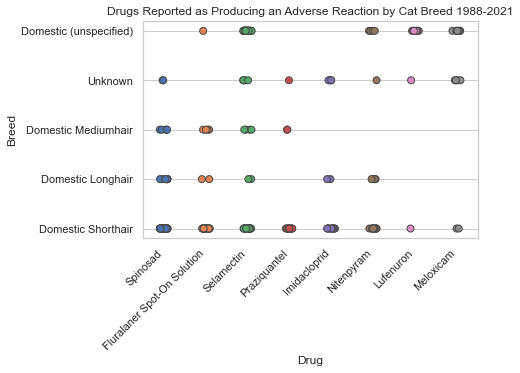

In [231]:
#does work for this data as it overlaps
#plt.figure(figsize = (8,3))
#create swarmplot plot
sns.stripplot(data=catdf, y='Breed', x='Drug', alpha=1.0, s=7, linewidth=1.0)

#create labels & display the title
plt.title("Drugs Reported as Producing an Adverse Reaction by Cat Breed 1988-2021")
#Rotate axis text
plt.xticks(rotation=45, ha='right')
#save image
plt.savefig("Drugs Reported as Producing an Adverse Reaction by Cat Breed 1988-2021 final3.png") 
#show plot
plt.show()

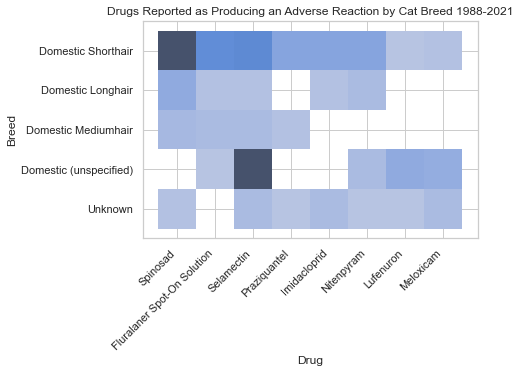

In [183]:
#same data in hist form

#create histogram plot
sns.histplot(data=catdf, y='Breed', x='Drug')
#create labels & display the title
plt.title("Drugs Reported as Producing an Adverse Reaction by Cat Breed 1988-2021")
#Rotate axis text
plt.xticks(rotation=45, ha='right')
#save image
plt.savefig("Drugs Reported as Producing an Adverse Reaction by Cat Breed 1988-2021 final2.png") 
#show plot
plt.show()

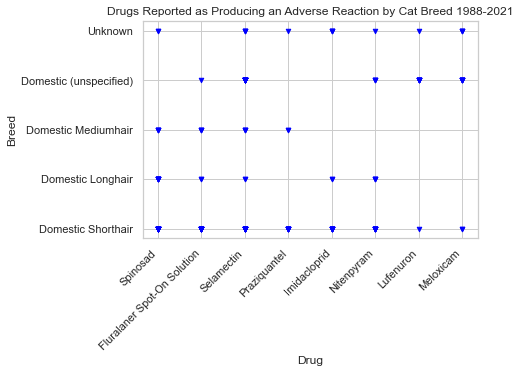

In [230]:
#create scatter plot
catdf.plot(kind='scatter', y='Breed', x='Drug', color="blue", marker="v")
#create labels & display the title
plt.title("Drugs Reported as Producing an Adverse Reaction by Cat Breed 1988-2021")
#Rotate axis text
plt.xticks(rotation=45, ha='right')
#save image
plt.savefig("Drugs Reported as Producing an Adverse Reaction by Cat Breed 1988-2021 final.png") 
#show plot
plt.show()

What are the top 3 drugs reported in these reactions? 
Selamectin, Spinosad, Fluralaner Spot-On Solution

In [70]:
#Limiting to top 3
d3=catdf['Drug'].value_counts()[:3]
d3

Selamectin                     73
Spinosad                       59
Fluralaner Spot-On Solution    27
Name: Drug, dtype: int64

Gathered information through distribution 

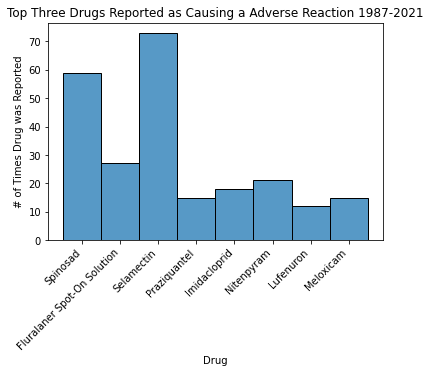

In [96]:
# drugs by top 3 
drugs=catdf['Drug']
#create plot
#fig, ax = plt.subplots()
#plots df "go-" creates a green line with circles
sns.histplot(drugs, bins=10)
#tick marks
#ax.tick_params('y', colors="green")
#labels
plt.xlabel("Drug")
plt.ylabel("# of Times Drug was Reported")
plt.title("Top Three Drugs Reported as Causing a Adverse Reaction 1987-2021")
#change size so labels fit
fig.set_size_inches([15, 4])
plt.xticks(rotation=45, ha='right')
plt.savefig("Top Three Drugs Reported as Causing a Adverse Reaction 1987-2021 hist final.png") 
plt.show()

Through bar graph limited to top three

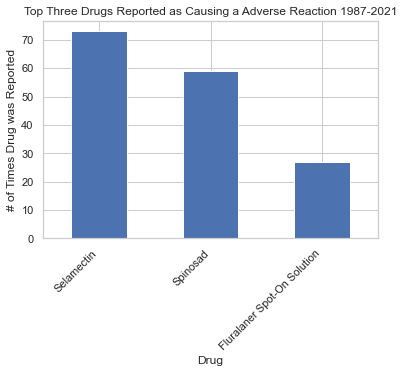

In [246]:
# drugs by top 3 
d3=catdf['Drug'].value_counts()[:3]
#create plot
fig, ax = plt.subplots()
#plots df "go-" creates a green line with circles
d3.plot(kind="bar")
#labels
plt.xlabel("Drug")
plt.ylabel("# of Times Drug was Reported")
plt.title("Top Three Drugs Reported as Causing a Adverse Reaction 1987-2021")
plt.xticks(rotation=45, ha='right')
#saving file
plt.savefig("Top Three Drugs Reported as Causing a Adverse Reaction 1987-2021 bar final.png") 
plt.show()

Which drugs were reported as producing an outcome of death?
This is explored by isolating a specific status of death and further looked at the drug; Selamectin, with the most reports of death as status

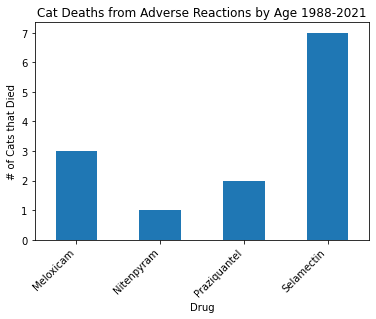

In [97]:
#sort data by deaths 
g=catdf[catdf["Status"] == 'Died']
#count deaths by age and sort order
h=g["Drug"].value_counts().sort_index()
#h
#create bar graph
h.plot(kind="bar", x="Age_y")
#create labels 
plt.xlabel("Drug")
plt.ylabel('# of Cats that Died' )
 
# display the title
plt.title("Cat Deaths from Adverse Reactions by Age 1988-2021")
#rotate axis label          
plt.xticks(rotation=45, ha='right')
#save image
plt.savefig("Number of Cat Deaths from Adverse Reactions by Age 1988-2021 final.png") 
#show plot
plt.show()

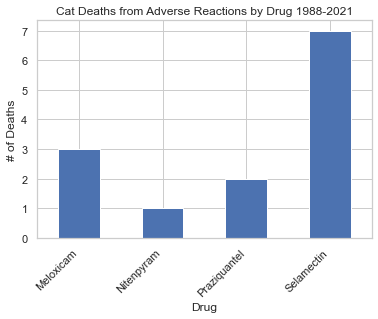

In [234]:
#sort data by deaths 
g=catdf[catdf["Status"] == 'Died']
#count deaths by age and sort order
h=g["Drug"].value_counts().sort_index()
#h
#create bar graph
h.plot(kind="bar", x="Drug")
#create labels 
plt.xlabel("Drug")
plt.ylabel('# of Deaths')
 
# display the title
plt.title("Cat Deaths from Adverse Reactions by Drug 1988-2021")
#rotate axis label          
plt.xticks(rotation=45, ha='right')
#save image
plt.savefig("Number of Cat Deaths from Adverse Reactions by Age 1988-2021 final.png") 
#show plot
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, menMeans, width, color='r')
ax.bar(ind, womenMeans, width,bottom=menMeans, color='b')
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_yticks(np.arange(0, 81, 10))
ax.legend(labels=['Men', 'Women'])
plt.show()

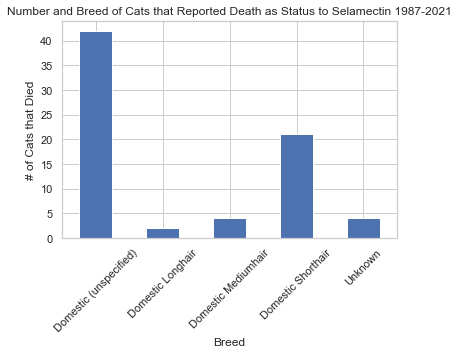

In [247]:
#Drug with the most deaths
#sort data by Selamectin deaths 
d=catdf[catdf["Drug"] == 'Selamectin']

#count deaths by breed and sort order
m=d["Breed"].value_counts().sort_index()

#create bar graph
m.plot(kind = "bar", x="breed")
#create labels 
plt.xlabel('Breed')
plt.ylabel('# of Cats that Died' )

# display the title
plt.title("Number and Breed of Cats that Reported Death as Status to Selamectin 1987-2021")
plt.xticks(rotation=45)
plt.savefig("Number and Breed of Cats that Reported Death as Status to Selamectin 1987-2021 Final.png") 
#show plot
plt.show()

Does gender have any importance in this data if so what affects does gender have? Also, is there an age affect taking place? More female cats are reported as having reactions. There is a rare occurance of hermaphoditic cats in the population data. More cats died at age 6 

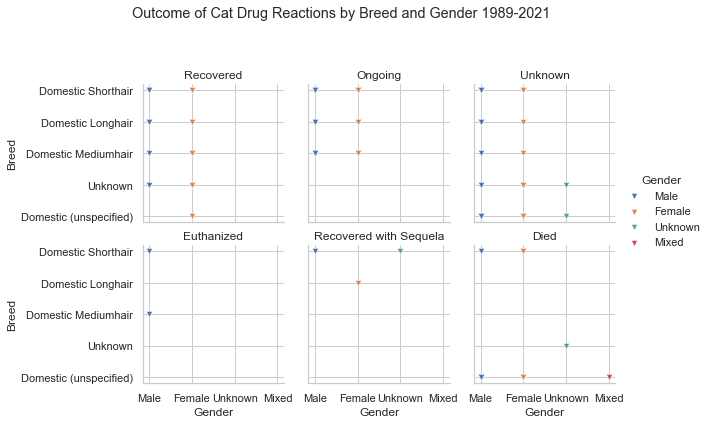

In [224]:
#Facet plots to look at outcomes, age, breed and gender effects/relationship
#organize the data in the grids
l = sns.FacetGrid(catdf, col="Status", hue="Gender", col_wrap=3)
#create plots
l.map(sns.scatterplot, "Gender", "Breed", marker='v')
#add gender legend
l.add_legend()
sns.set(style = 'whitegrid')
#enlarge plots
plt.subplots_adjust(top=0.8)
l.set_titles("{col_name}")
#title for grids
l.fig.suptitle('Outcome of Cat Drug Reactions by Breed and Gender 1989-2021')
plt.savefig("Outcome of Cat Drug Reactions by Breed and Gender 1989-2021 Final.png") 
#show plot
#plt.tight_layout()  
plt.show()

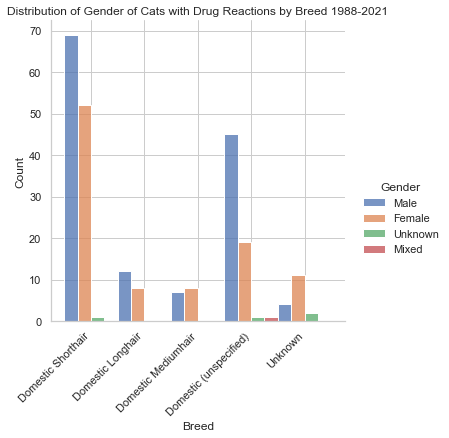

In [263]:
#create histogram plot
#sns.scatterplot(data=catdf, y='Gender', x='Breed' )
sns.displot(catdf, x="Breed", hue="Gender", multiple="dodge")
#create labels & display the title
plt.title("Distribution of Gender of Cats with Drug Reactions by Breed 1988-2021")
#Rotate axis text
plt.xticks(rotation=45, ha='right')
#save image
plt.savefig("Distro Gender of Cats as with a Adverse Reaction by Cat Breed 1988-2021 final.png") 
#show plot
plt.show()

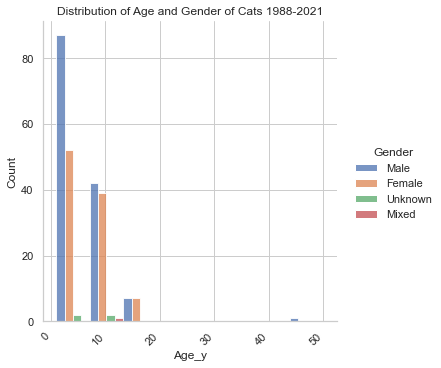

In [269]:
#create histogram plot
#sns.scatterplot(data=catdf, y='Gender', x='Breed' )
sns.displot(catdf, x="Age_y", hue="Gender", multiple="dodge", bins=8)
#create labels & display the title
plt.title("Distribution of Age and Gender of Cats 1988-2021")
#Rotate axis text
plt.xticks(rotation=45, ha='right')
#save image
plt.savefig("Distribution of Age and Gender of Cats 1988-2021final.png") 
#show plot
plt.show()

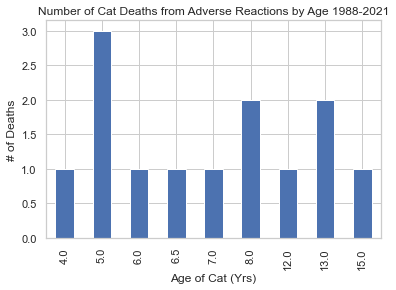

In [264]:
#sort data by deaths 
g=catdf[catdf["Status"] == 'Died']
#count deaths by age and sort order
h=g["Age_y"].value_counts().sort_index()
#h
#create bar graph
h.plot(kind="bar", x="Age_y", )
#create labels 
plt.xlabel('Age of Cat (Yrs)')
plt.ylabel('# of Deaths')
 
# display the title
plt.title("Number of Cat Deaths from Adverse Reactions by Age 1988-2021")
#plt.xticks(rotation=45, ha='right')
#save image
plt.savefig("Number of Cat Deaths by Age 1988-2021 Final.png") 
#show plot
plt.show()

Does breed have an affect on status

C:\Users\chdar\AppData\Local\Temp/ipykernel_12496/4018830541.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


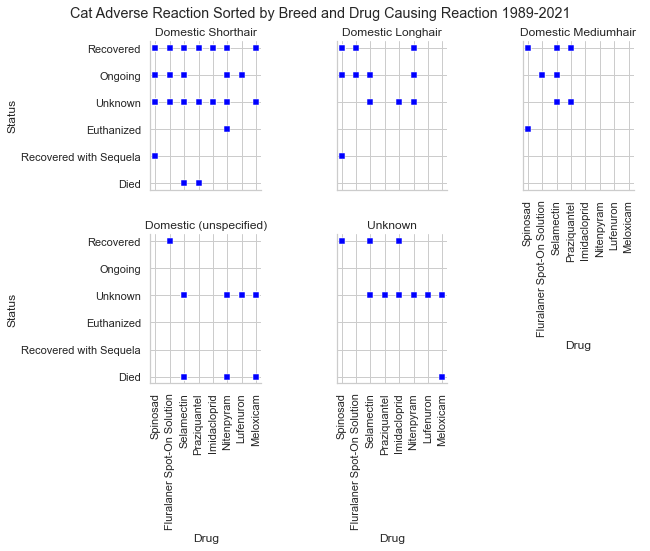

In [245]:
#Facet plots to look at outcomes, age, breed and gender effects/relationship
#organize the data in the grids
z = sns.FacetGrid(catdf, col="Breed", col_wrap=3)
#create plots
z.map(sns.scatterplot, "Drug", "Status", marker="s", color="blue")
#add gender legend
z.add_legend()
#enlarge plots
#plt.subplots_adjust(top=1.1)
for axes in z.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
#plt.tight_layout()     
#plt.xticks(rotation=90, ha='right')
z.set_titles("{col_name}")
#title for grids
z.fig.suptitle('Cat Adverse Reaction Sorted by Breed and Drug Causing Reaction 1989-2021')
#move plots down to fit title
plt.subplots_adjust(top=0.9)
plt.savefig("Cat Adverse Reaction Sorted by Breed and Drug Causing Reaction 1989-2021 Final.png") 
plt.show()

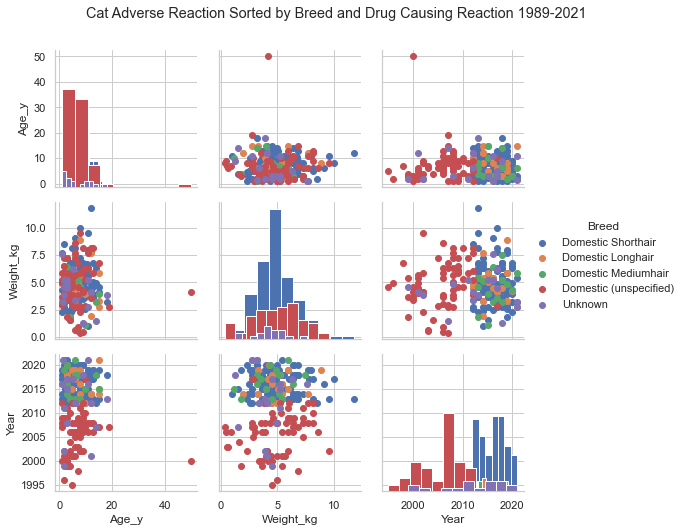

In [241]:
breeds = sns.PairGrid(catdf, hue="Breed").map_diag(plt.hist)
breeds.map_offdiag(plt.scatter)
breeds.add_legend()
breeds.fig.suptitle('Cat Adverse Reaction Sorted by Breed and Drug Causing Reaction 1989-2021')
plt.subplots_adjust(top=0.9)
plt.savefig("Distro of data Final.png") 
plt.show()